Notebook base sacada de: https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/notebook#Importing-Libraries

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
#import librosa.display # Aparentemente esto bugea todo segun un git issue 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from joblib import dump, load

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [2]:
base_url = "C:/Users/Equipo/Documents/Github/SER/datasets"

# Paths for data.
Ravdess = f"{base_url}/RAVDESS/audio_speech_actors_01-24"
Crema = f"{base_url}/CREMA"
Tess = f"{base_url}/TESS"
Savee = f"{base_url}/SAVEE"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + f'/{dir}')
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + f'/{dir}/{file}')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
1  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
2  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
3  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
4     calm  C:/Users/Equipo/Documents/Github/SER/datasets/...

## <center>2. Crema DataFrame</center>

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
1  disgust  C:/Users/Equipo/Documents/Github/SER/datasets/...
2     fear  C:/Users/Equipo/Documents/Github/SER/datasets/...
3    happy  C:/Users/Equipo/Documents/Github/SER/datasets/...
4  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...

##  <center> 3. TESS dataset <center>

In [8]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + f'/{dir}')
    for file in directories:
        
        # Posible error que esta perdiendo data
        try:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess +'/' + dir + '/' + file)
        except:
            pass
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
1    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
2    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
3    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
4    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...

##  <center> 4. Savee dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [9]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
1    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
2    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
3    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...
4    angry  C:/Users/Equipo/Documents/Github/SER/datasets/...

In [10]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
# data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
1  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
2  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
3  neutral  C:/Users/Equipo/Documents/Github/SER/datasets/...
4     calm  C:/Users/Equipo/Documents/Github/SER/datasets/...

In [11]:
# Necesario preprocess
data_path['Emotions'] = data_path['Emotions'].replace('surprised','surprise')

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

ValueError: could not convert string to float: 'neutral'

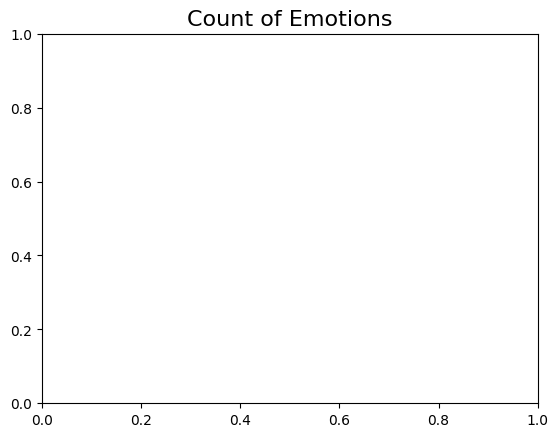

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [16]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    #librosa.display.waveplot(data, sr=sr)
    # por temas de compatibilidad
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

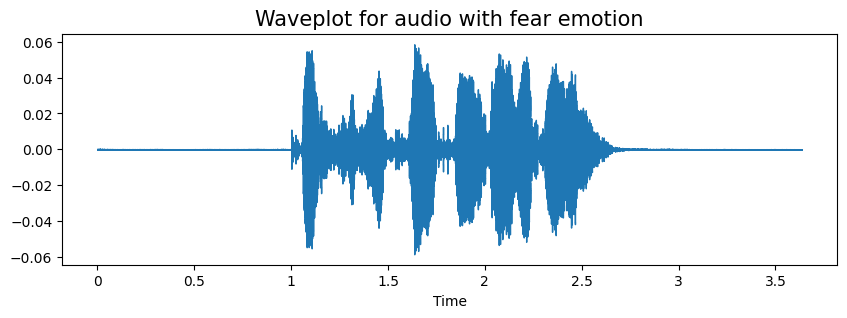

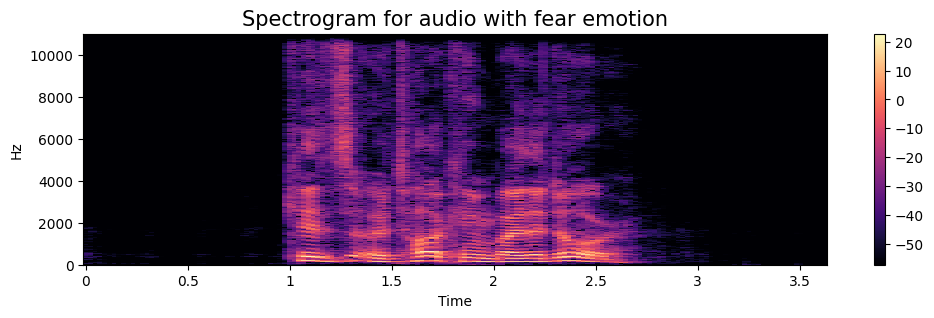

In [17]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

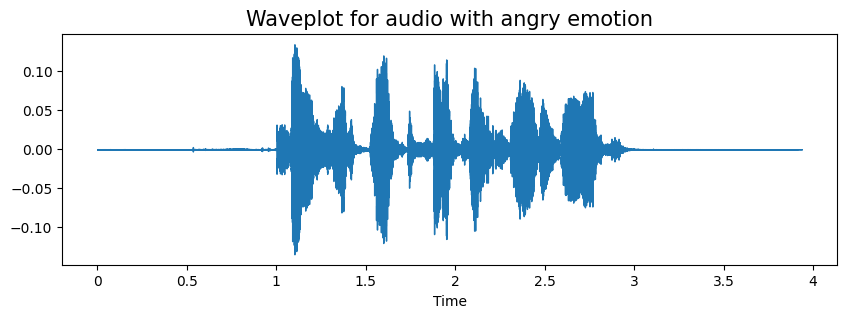

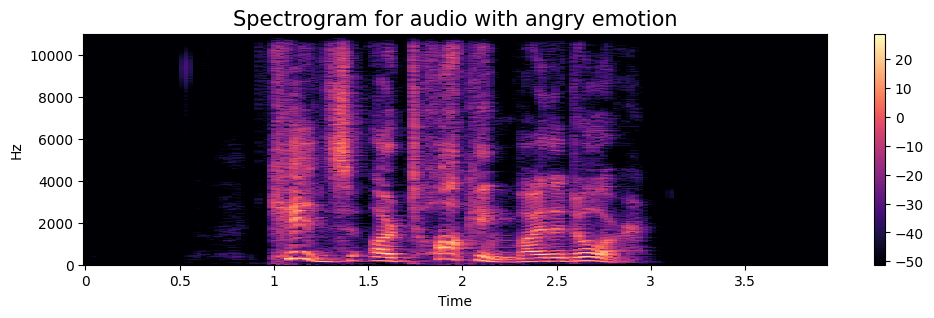

In [18]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

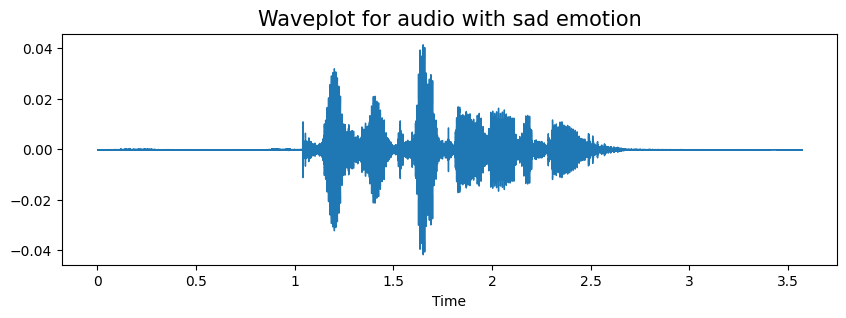

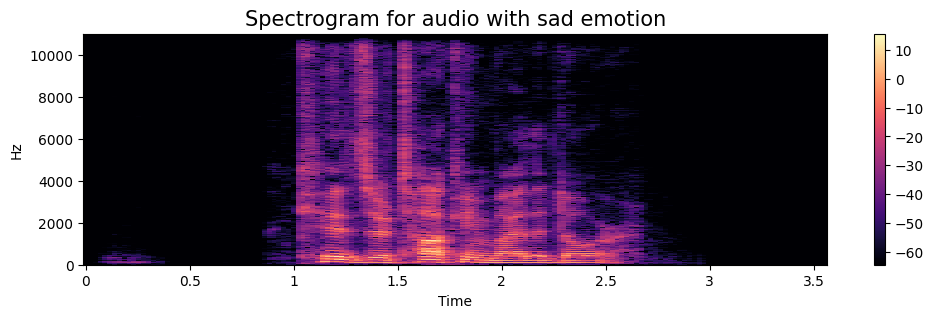

In [19]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

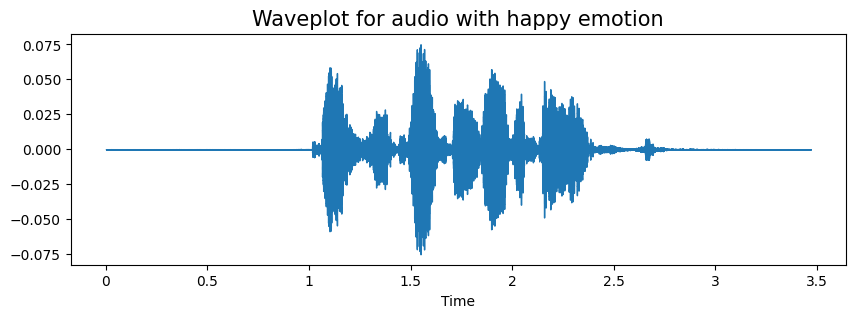

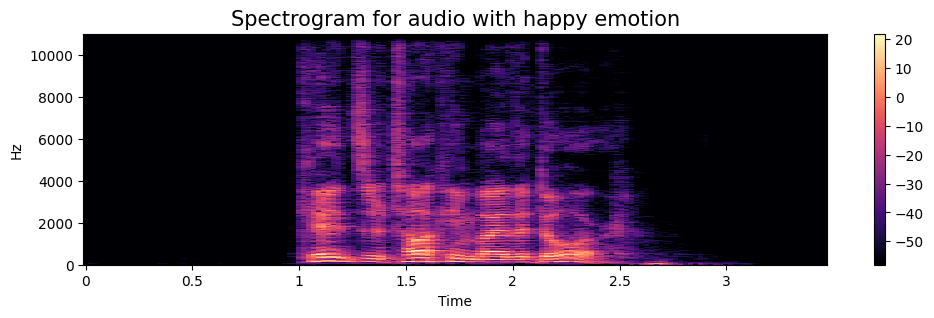

In [20]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [21]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    #     return librosa.effects.time_stretch(data, rate)
    # Compatibility issues
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

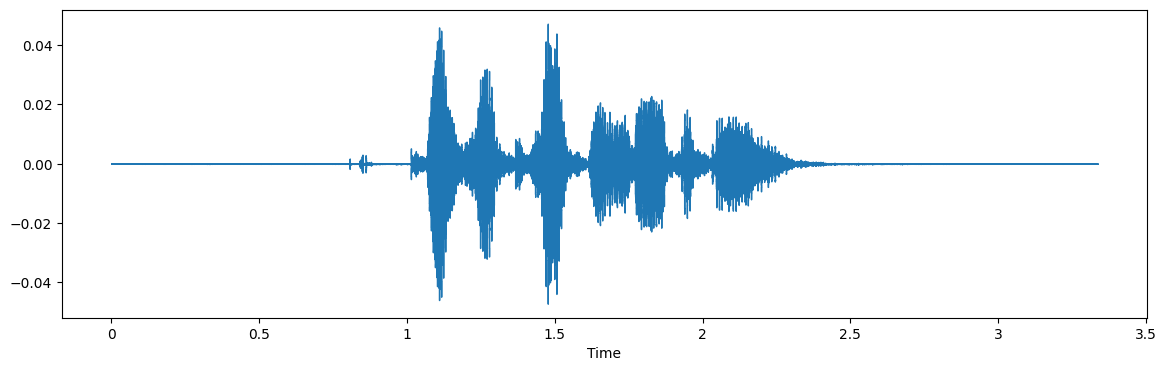

In [22]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

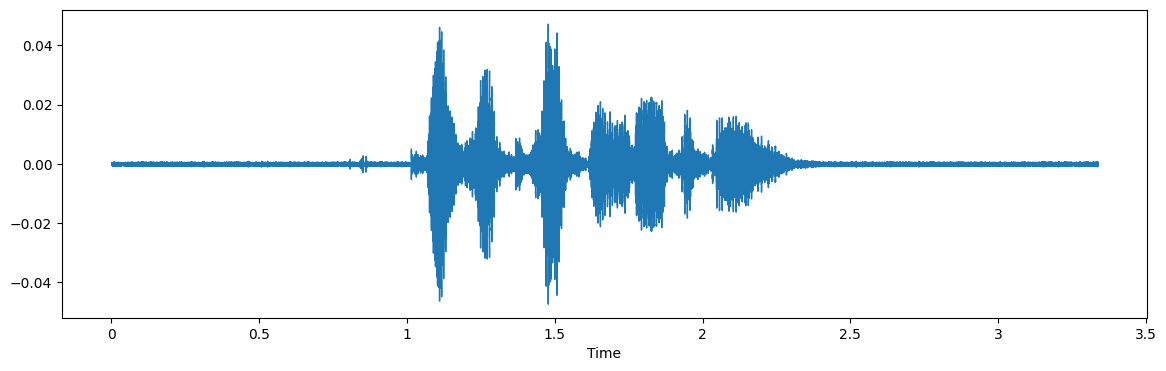

In [23]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

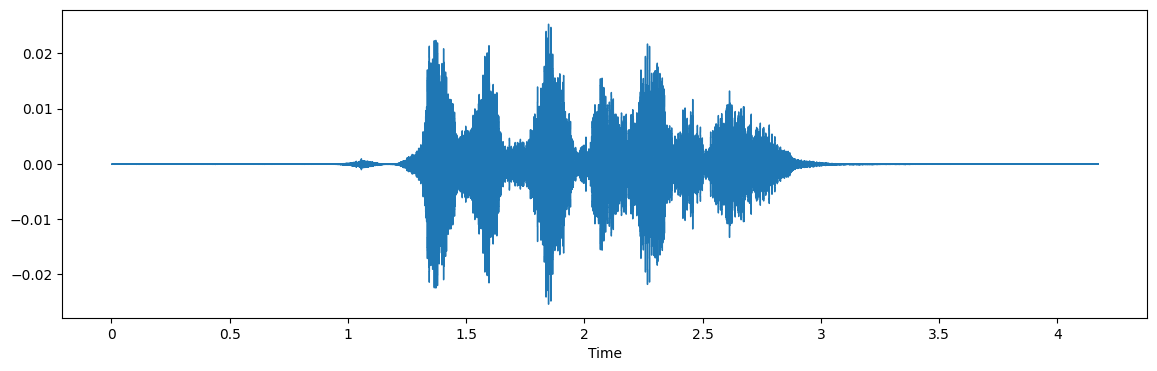

In [24]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

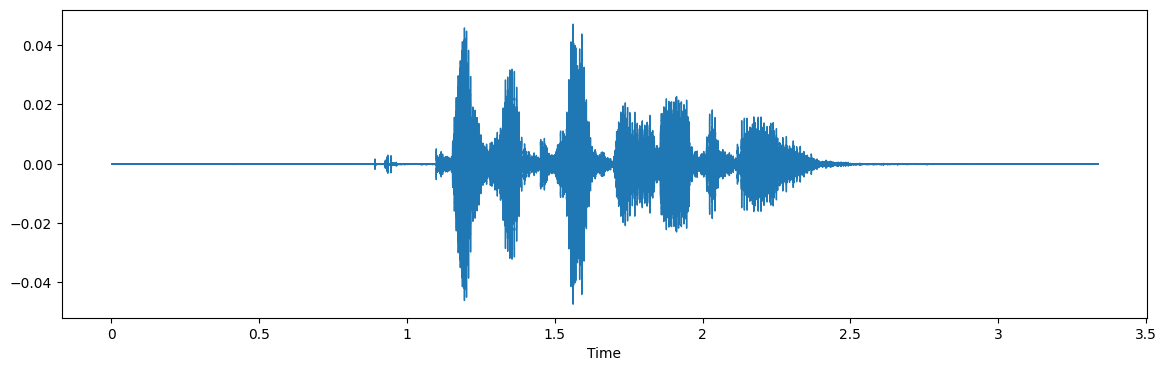

In [25]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

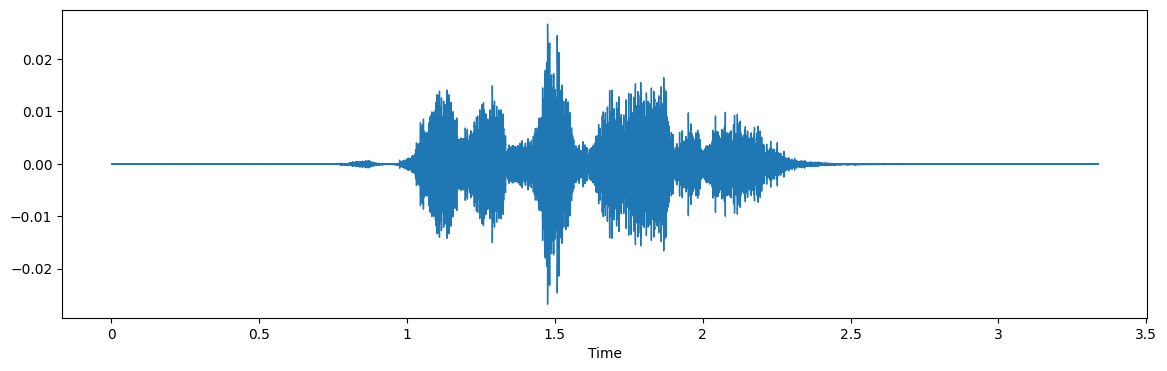

In [26]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [27]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [28]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    print(path)
    print(emotion)
    
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-02-01.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-02-01-01.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-02-02-01.wav
calm
C:/Users/Equipo/Documents/Github/SER

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-02-02-02-02-02.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-03-01-01-01-02.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-03-01-01-02-02.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-03-01-02-01-02.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-03-01-02-02-02.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-03-02-01-01-02.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-03-02-01-02-02.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_02/03-01-03-02-02-01-02.wav
happy
C:/Users/Equipo/Documents/Github/SER/data

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-04-01-02-01-03.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-04-01-02-02-03.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-04-02-01-01-03.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-04-02-01-02-03.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-04-02-02-01-03.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-04-02-02-02-03.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-05-01-01-01-03.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_03/03-01-05-01-01-02-03.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDES

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-05-01-02-02-04.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-05-02-01-01-04.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-05-02-01-02-04.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-05-02-02-01-04.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-05-02-02-02-04.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-06-01-01-01-04.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-06-01-01-02-04.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-06-01-02-01-04.wav
fear
C:/Users/Equipo/Documents/Github/SER/datase

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-06-02-02-01-05.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-06-02-02-02-05.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-07-01-01-01-05.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-07-01-01-02-05.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-07-01-02-01-05.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-07-01-02-02-05.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-07-02-01-01-05.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_05/03-01-07-02-01-02-05.wav
disgust
C:/Users/Equipo/Documents/Gith

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-07-02-02-02-06.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-08-01-01-01-06.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-08-01-01-02-06.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-08-01-02-01-06.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-08-01-02-02-06.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-08-02-01-01-06.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-08-02-01-02-06.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-08-02-02-01-06.wav
surprise
C:/Users/Equipo/D

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_07/03-01-08-02-02-02-07.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-01-01-01-01-08.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-01-01-01-02-08.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-01-01-02-01-08.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-01-01-02-02-08.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-02-01-01-01-08.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-02-01-01-02-08.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_08/03-01-02-01-02-01-08.wav
calm
C:/Users/Equipo/Documents/Github

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-02-02-02-01-09.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-02-02-02-02-09.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-03-01-01-01-09.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-03-01-01-02-09.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-03-01-02-01-09.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-03-01-02-02-09.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-03-02-01-01-09.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-03-02-01-02-09.wav
happy
C:/Users/Equipo/Documents/Github/SER/datas

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-03-02-02-02-10.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-04-01-01-01-10.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-04-01-01-02-10.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-04-01-02-01-10.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-04-01-02-02-10.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-04-02-01-01-10.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-04-02-01-02-10.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_10/03-01-04-02-02-01-10.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-01-01-01-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-01-01-02-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-01-02-01-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-01-02-02-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-02-01-01-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-02-01-02-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-02-02-01-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-02-02-02-11.wav
angry
C:/Users/Equipo/Documents/Github/SER/dat

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-06-01-02-01-12.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-06-01-02-02-12.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-06-02-01-01-12.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-06-02-01-02-12.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-06-02-02-01-12.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-06-02-02-02-12.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-07-01-01-01-12.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-07-01-01-02-12.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datas

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-07-02-01-01-13.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-07-02-01-02-13.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-07-02-02-01-13.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-07-02-02-02-13.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-08-01-01-01-13.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-08-01-01-02-13.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-08-01-02-01-13.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_13/03-01-08-01-02-02-13.wav
surprise
C:/Users/Equipo/Docu

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-08-02-01-02-14.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-08-02-02-01-14.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-08-02-02-02-14.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-01-01-01-01-15.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-01-01-01-02-15.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-01-01-02-01-15.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-01-01-02-02-15.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-02-01-01-01-15.wav
calm
C:/Users/Equipo/Document

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-02-01-02-02-16.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-02-02-01-01-16.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-02-02-01-02-16.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-02-02-02-01-16.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-02-02-02-02-16.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-03-01-01-01-16.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-03-01-01-02-16.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_16/03-01-03-01-02-01-16.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-03-02-01-02-17.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-03-02-02-01-17.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-03-02-02-02-17.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-04-01-01-01-17.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-04-01-01-02-17.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-04-01-02-01-17.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-04-01-02-02-17.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-04-02-01-01-17.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVD

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-04-02-02-02-18.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-02-18.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-01-02-01-18.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-01-02-02-18.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-02-01-01-18.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-02-01-02-18.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_18/03-01-05-02-02-01-18.wav
angry
C:/Users/Equipo/Documents/Github/SER/datas

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-06-01-02-01-19.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-06-01-02-02-19.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-06-02-01-01-19.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-06-02-01-02-19.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-06-02-02-01-19.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-06-02-02-02-19.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-07-01-01-01-19.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_19/03-01-07-01-01-02-19.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datas

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-07-02-01-01-20.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-07-02-01-02-20.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-07-02-02-01-20.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-07-02-02-02-20.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-08-01-01-01-20.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-08-01-01-02-20.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-08-01-02-01-20.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_20/03-01-08-01-02-02-20.wav
surprise
C:/Users/Equipo/Docu

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_21/03-01-08-02-01-02-21.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_21/03-01-08-02-02-01-21.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_21/03-01-08-02-02-02-21.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_22/03-01-01-01-01-01-22.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_22/03-01-01-01-01-02-22.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_22/03-01-01-01-02-01-22.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_22/03-01-01-01-02-02-22.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_22/03-01-02-01-01-01-22.wav
calm
C:/Users/Equipo/Document

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-02-01-02-01-23.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-02-01-02-02-23.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-02-02-01-01-23.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-02-02-01-02-23.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-02-02-02-01-23.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-02-02-02-02-23.wav
calm
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-03-01-01-01-23.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-03-01-01-02-23.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/

C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-03-02-01-02-24.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-03-02-02-01-24.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-03-02-02-02-24.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-04-01-01-01-24.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-04-01-01-02-24.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-04-01-02-01-24.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-04-01-02-02-24.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVDESS/audio_speech_actors_01-24/Actor_24/03-01-04-02-01-01-24.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/RAVD

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1001_IWW_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1002_TSI_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1004_IEO_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1005_IWL_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1006_TIE_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1007_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1007_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1007_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1007_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1007_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1007_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1008_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1008_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1008_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1008_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1008_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1008_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1008_IEO_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1009_ITS_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1010_TIE_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1011_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1011_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1011_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1011_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1011_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1012_IEO_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1013_ITH_HAP_XX.

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1014_MTI_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1015_WSI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_HAP_MD.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1017_IE

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1018_IWL_N

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1019_TSI_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1021_IEO_HA

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1022_IWL_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1023_TAI_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1024_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1024_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1024_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1024_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1024_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1024_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1025_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1025_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1025_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1025_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1025_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1025_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1025_IEO_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1026_ITH_FEA_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1027_MTI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1028_WSI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_HAP_MD.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1030_IE

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1031_IWL_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1032_TIE_H

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1033_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1033_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1034_IEO_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1035_ITH_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1036_TAI_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1037_WSI_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_HAP_MD.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1039_IOM_FEA_XX.w

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1040_IWW_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1041_TSI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1043_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1044_ITS_H

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1045_TAI_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1046_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1047_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1047_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1047_DFA_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IEO_HAP_MD.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1048_IOM_SAD_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1049_MTI_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1050_TSI_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1052_IEO_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1053_IWL_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1054_TIE_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1055_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1055_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1055_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1055_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1055_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1056_IEO_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1057_ITH_FEA_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1058_MTI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1059_WSI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_HAP_MD.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1061_IE

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1062_IWL_N

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1063_TIE_N

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1064_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1064_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1065_IEO_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1066_ITS_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1067_TAI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1068_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1069_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1069_DFA_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_HAP_MD.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1070_IOM_FEA_XX.w

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1071_IWW_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1072_TSI_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1074_IEO_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1075_ITS_H

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1076_TAI_S

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1077_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1077_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1077_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1077_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1077_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1077_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1078_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1078_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1078_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1078_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1078_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1078_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1078_IEO_A

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IOM_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IOM_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1079_ITH_FEA_

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWW_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1080_MTI_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1081_WSI_H

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_FEA_LO.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_FEA_MD.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_HAP_HI.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_HAP_LO.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_HAP_MD.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_SAD_HI.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_SAD_LO.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IEO_SAD_MD.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1083_IOM_ANG_XX

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_ITS_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_ITS_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_ITS_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_ITS_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWL_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWL_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWL_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWL_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWL_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWL_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWW_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1084_IWW_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TAI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TAI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TAI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TAI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TIE_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TIE_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TIE_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TIE_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TIE_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TIE_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1085_TSI_D

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_DFA_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_DFA_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_DFA_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_DFA_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_IEO_ANG_HI.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_IEO_ANG_LO.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_IEO_ANG_MD.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_IEO_DIS_HI.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_IEO_DIS_LO.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_IEO_DIS_MD.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_IEO_FEA_HI.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1087_I

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_IOM_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_IOM_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_IOM_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_IOM_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITH_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITH_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITH_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITH_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITH_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITH_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITS_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITS_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1088_ITS_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_IWW_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_IWW_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_IWW_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_IWW_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_MTI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_MTI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_MTI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_MTI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_MTI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_MTI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_TAI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_TAI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1089_TAI_F

C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_TSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_TSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_TSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_TSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_WSI_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_WSI_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_WSI_FEA_XX.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_WSI_HAP_XX.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_WSI_NEU_XX.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1090_WSI_SAD_XX.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1091_DFA_ANG_XX.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1091_DFA_DIS_XX.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/CREMA/1091_DFA_F

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_calm_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_came_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_cause_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_chain_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_chair_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_chalk_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_chat_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_check_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_cheek_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_chief_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_choice_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_name_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_near_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_neat_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_nice_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_note_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_numb_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_pad_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_page_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_pain_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_pass_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_angry/OAF_pearl_angry.wav
angry
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_beg_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_bite_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_boat_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_bone_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_book_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_bought_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_burn_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_cab_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_calm_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_came_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_cause_disgust

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_luck_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_make_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_match_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_merge_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_mess_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_met_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_mill_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_mob_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_mode_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_mood_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_moon_disgust.

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_walk_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_wash_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_week_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_wheat_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_when_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_which_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_whip_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_white_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_wife_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_wire_disgust.wav
disgust
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_disgust/OAF_witch_disg

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_learn_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_lease_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_lid_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_life_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_limb_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_live_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_loaf_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_long_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_lore_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_lose_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_lot_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_love_fear.wav
fear
C:/U

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_walk_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_wash_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_week_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_wheat_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_when_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_which_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_whip_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_white_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_wife_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_wire_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_witch_fear.wav
fear
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Fear/OAF_yearn_fear.wav
fear

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_lean_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_learn_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_lease_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_lid_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_life_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_limb_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_live_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_loaf_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_long_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_lore_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_lose_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OA

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_voice_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_void_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_vote_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_wag_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_walk_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_wash_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_week_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_wheat_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_when_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_which_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_happy/OAF_whip_happy.wav
happy
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/O

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_keep_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_keg_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_kick_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_kill_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_king_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_kite_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_knock_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_late_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_laud_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_lean_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_learn_neutral

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_talk_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_tape_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_team_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_tell_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_thin_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_third_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_thought_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_thumb_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_time_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_tip_neutral.wav
neutral
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_neutral/OAF_tire_neut

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_goal_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_good_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_goose_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_gun_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_half_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_hall_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_hash_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_hate_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_have_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_haze_ps.wav
surprise
C:/Users/Equipo/Docu

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_red_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_ring_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_ripe_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_road_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_room_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_rose_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_rot_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_rough_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_rush_ps.wav
surprise
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Pleasant_surprise/OAF_said_ps.wav
surprise
C:/Users/Equipo/Docum

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_dab_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_date_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_dead_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_death_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_deep_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_dime_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_dip_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_ditch_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_dodge_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_dog_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_doll_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_door_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/dat

C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_raid_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_rain_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_raise_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_rat_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_reach_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_read_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_red_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_ring_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_ripe_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_road_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_room_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/datasets/TESS/OAF_Sad/OAF_rose_sad.wav
sad
C:/Users/Equipo/Documents/Github/SER/dat

PermissionError: [Errno 13] Permission denied: 'C:/Users/Equipo/Documents/Github/SER/datasets/TESS/TESS Toronto emotional speech set data/OAF_Pleasant_surprise'

In [30]:
len(X), len(Y), data_path.Path.shape

(30846, 30846, (12164,))

In [31]:
Features = pd.DataFrame(X)
Features['labels'] = Y
# Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750033  0.730624  0.735275  0.713529  0.660531   
1  0.322722  0.816987  0.828176  0.807366  0.818365  0.815103  0.696744   
2  0.188256  0.622128  0.699219  0.753332  0.721223  0.701737  0.682353   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.272768  0.720301  0.775601  0.750818  0.724016  0.740106  0.708917   

          7         8         9  ...           153           154  \
0  0.684966  0.733049  0.753972  ...  4.310903e-06  3.291511e-06   
1  0.686613  0.735860  0.772864  ...  7.579086e-05  7.640565e-05   
2  0.662828  0.686490  0.733966  ...  8.576332e-07  9.576413e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034949e-06   
4  0.627023  0.663744  0.694670  ...  1.048160e-05  1.093860e-05   

            155           156           157           158       159       160  \
0  2.148075e-06  2.279739e-06  5.116493e-06  8.190282e-06  0.000007  0.000005   
1  7.191412e-05  7.193127e-05  7.830140e-05  8.093409e-05  0.000079  0.000077   
2  7.733595e-07  5.233102e-07  3.592796e-07  9.261686e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640183e-06  0.000011  0.000006   
4  1.054514e-05  1.054645e-05  1.585815e-05  1.322814e-05  0.000015  0.000009   

            161   labels  
0  4.245834e-07  neutral  
1  7.031484e-05  neutral  
2  7.753985e-08  neutral  
3  4.254087e-07  neutral  
4  4.241762e-06  neutral  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [32]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [33]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [34]:
# Para guardar parametros del encoder
# dump(encoder, 'encoder.bin', compress=True)

['encoder.bin']

In [35]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((23134, 162), (23134, 8), (7712, 162), (7712, 8))

In [36]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((23134, 162), (23134, 8), (7712, 162), (7712, 8))

In [38]:
# Guardar standar scaler
# dump(scaler, 'std_scaler.bin', compress=True)

In [39]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((23134, 162, 1), (23134, 8), (7712, 162, 1), (7712, 8))

## Modelling

In [40]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [41]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
362/362 [==============================] - 24s 63ms/step - loss: 1.7264 - accuracy: 0.3047 - val_loss: 1.5346 - val_accuracy: 0.3736 - lr: 0.0010
Epoch 2/50
362/362 [==============================] - 25s 68ms/step - loss: 1.5383 - accuracy: 0.3768 - val_loss: 1.4563 - val_accuracy: 0.4098 - lr: 0.0010
Epoch 3/50
362/362 [==============================] - 26s 72ms/step - loss: 1.4670 - accuracy: 0.4051 - val_loss: 1.3918 - val_accuracy: 0.4335 - lr: 0.0010
Epoch 4/50
362/362 [==============================] - 27s 75ms/step - loss: 1.4149 - accuracy: 0.4309 - val_loss: 1.3319 - val_accuracy: 0.4669 - lr: 0.0010
Epoch 5/50
362/362 [==============================] - 27s 74ms/step - loss: 1.3752 - accuracy: 0.4501 - val_loss: 1.3205 - val_accuracy: 0.4759 - lr: 0.0010
Epoch 6/50
362/362 [==============================] - 26s 72ms/step - loss: 1.3537 - accuracy: 0.4591 - val_loss: 1.3027 - val_accuracy: 0.4748 - lr: 0.0010
Epoch 7/50
362/362 [==============================] - 26s 

241/241 [==============================] - 3s 11ms/step - loss: 1.2908 - accuracy: 0.5581
Accuracy of our model on test data :  55.809128284454346 %


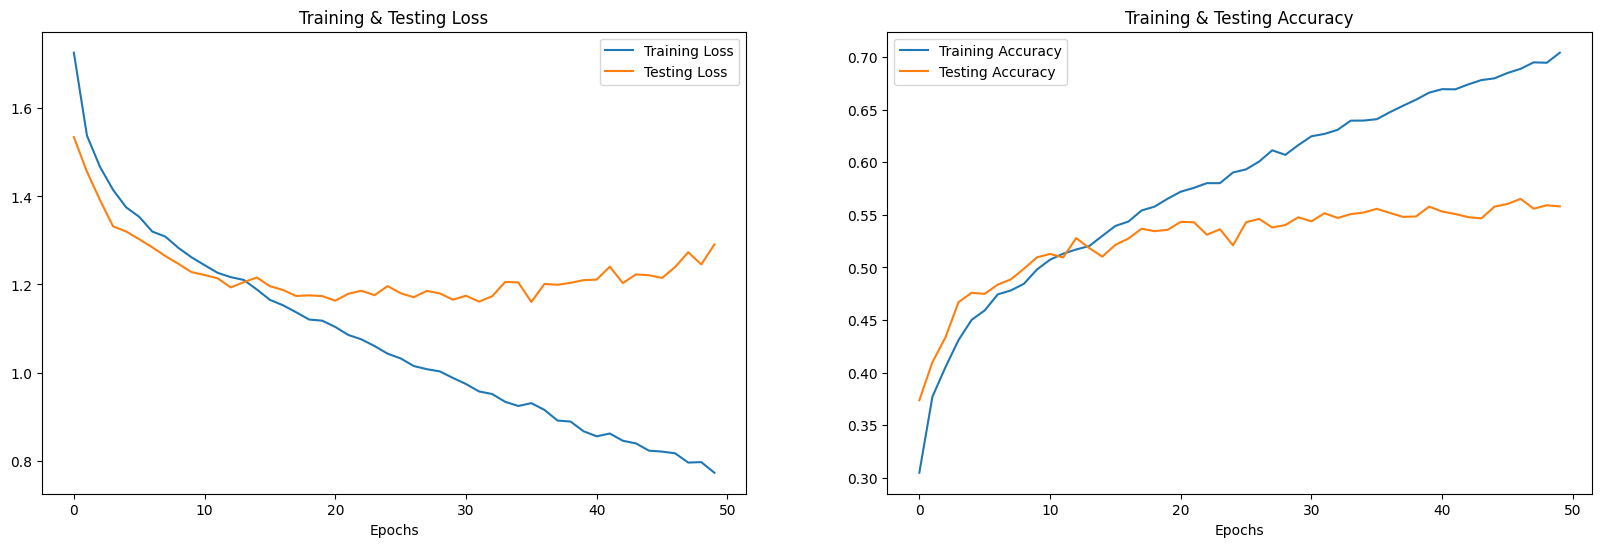

In [42]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [43]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

241/241 [==============================] - 3s 11ms/step


In [44]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad          fear
1            happy         happy
2             fear          fear
3          disgust          fear
4            angry         angry
5            angry         happy
6            happy          fear
7             fear         happy
8          disgust       neutral
9            happy          fear

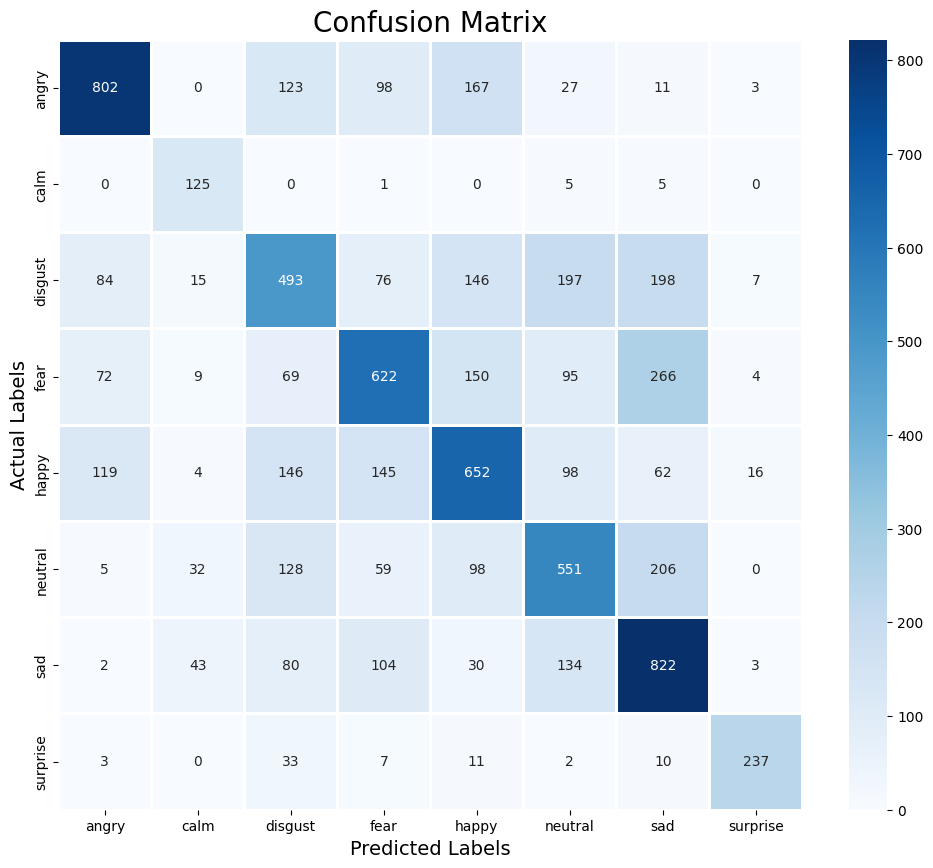

In [45]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.65      0.69      1231
        calm       0.55      0.92      0.69       136
     disgust       0.46      0.41      0.43      1216
        fear       0.56      0.48      0.52      1287
       happy       0.52      0.52      0.52      1242
     neutral       0.50      0.51      0.50      1079
         sad       0.52      0.67      0.59      1218
    surprise       0.88      0.78      0.83       303

    accuracy                           0.56      7712
   macro avg       0.59      0.62      0.60      7712
weighted avg       0.56      0.56      0.56      7712



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

In [49]:
model.save('BASE_MODEL_19_05_2023.h5')